In [1]:
import numpy as np
import cv2
import math
import random
import matplotlib
from math import *
from matplotlib import pyplot as plt
%matplotlib inline

## R,G,B channel 

In [2]:
img = plt.imread('images/Fig0646(a)(lenna_original_RGB).tif')

r = img[:,:,0]
g = img[:,:,1]
b = img[:,:,2]

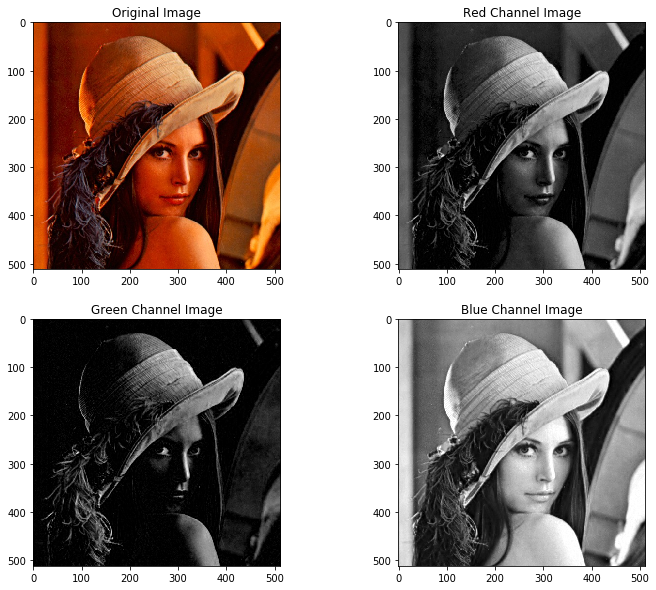

In [3]:
# Display results
display = [img, g, b, r]
label = ['Original Image', 'Red Channel Image', 'Green Channel Image', 'Blue Channel Image']

fig = plt.figure(figsize=(12, 10))

for i in range(len(display)):
    fig.add_subplot(2, 2, i+1)
    if i>0:
        plt.imshow(display[i],'gray')
    else:
         plt.imshow(display[i])
    plt.title(label[i])

plt.show()

## Hue, Saturation and Intensity

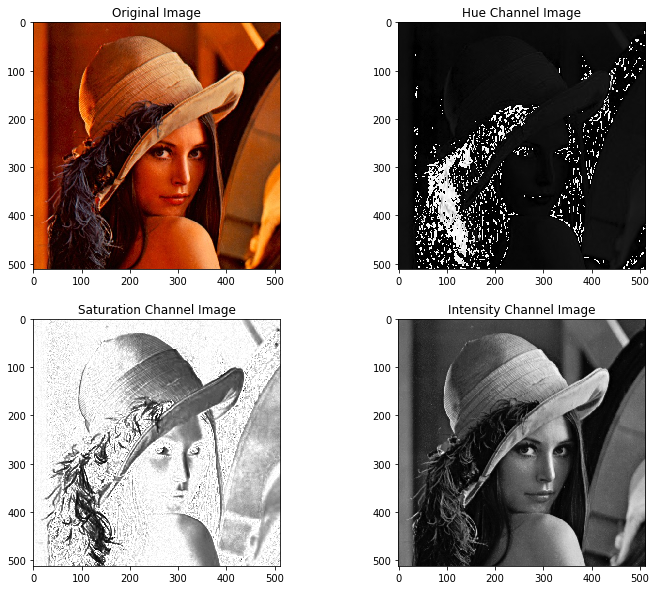

In [26]:
# 参考：https://github.com/SVLaursen/Python-RGB-to-HSI/blob/master/converter.py
#Calculate Intensity
def calc_intensity(red, blue, green):
    return np.divide(blue + green + red, 3)

#Calculate Saturation
def calc_saturation(red, blue, green):
    minimum = np.minimum(np.minimum(red, green), blue)
    saturation = 1 - (3 / (red + green + blue + 0.001) * minimum)

    return saturation

#Calculate Hue
def calc_hue(red, blue, green):
    with np.errstate(divide='ignore', invalid='ignore'):
        hue = np.copy(red)
        for i in range(0, blue.shape[0]):
            for j in range(0, blue.shape[1]):
                hue[i][j] = 0.5 * ((red[i][j] - green[i][j]) + (red[i][j] - blue[i][j])) / \
                            math.sqrt((red[i][j] - green[i][j])**2 +
                                    ((red[i][j] - blue[i][j]) * (green[i][j] - blue[i][j]))+1e-8)
                
                hue[i][j] = math.acos(hue[i][j])
               
                if blue[i][j] <= green[i][j]:
                    hue[i][j] = hue[i][j]
                else:
                    hue[i][j] = ((360 * math.pi) / 180.0) - hue[i][j]
                
                

        return hue
img = plt.imread('images/Fig0646(a)(lenna_original_RGB).tif')
# 注意计算前须归一化到[0-1]
r = img[:,:,0].astype('float')/255.
g = img[:,:,1].astype('float')/255.
b = img[:,:,2].astype('float')/255.

h,s,i = calc_hue(r,b,g),calc_saturation(r,b,g),calc_intensity(r,b,g)
h = h/((360 * math.pi) / 180.0) # 最后的h需要除360度，其余的s,i已经在[0-1]之内


# Display results
display = [img, h, s, i]
label = ['Original Image', 'Hue Channel Image', 'Saturation Channel Image', 'Intensity Channel Image']

fig = plt.figure(figsize=(12, 10))

for i in range(len(display)):
    fig.add_subplot(2, 2, i+1)
    if i>0:
        plt.imshow(display[i],'gray')
    else:
         plt.imshow(display[i])
    plt.title(label[i])

plt.show()

## pseudo-color image processing

Text(0.5, 1.0, 'Pseudo-Color Image')

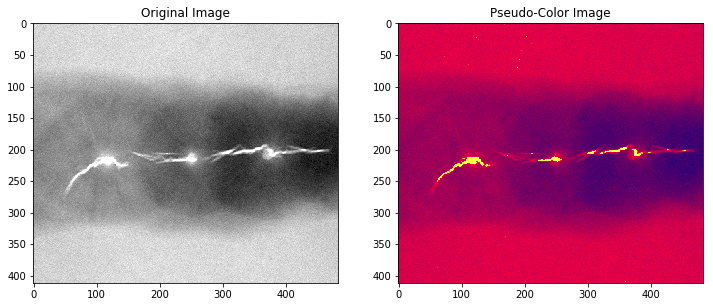

In [31]:
def pixelVal(pix, r1, s1): 
    if (0 <= pix and pix <= r1): 
        return 0.0
    elif (pix > r1): 
        return (pix-r1)/(1-r1)
# 类似于pandas的apply，可以将函数应用在数组的每一个元素上 
pixelVal_vec = np.vectorize(pixelVal) 
path = 'images/Fig0621(a)(weld-original).tif'
gray = cv2.imread(path,0)
gray_f = gray.astype('float')/255.

# Blue y=-0.25x+0.5
B = -0.25*gray_f + 0.5
G = pixelVal_vec(gray_f, 0.97, 1)
R = gray_f.copy()

pseudo_rgb = cv2.merge((R,G,B))
fig = plt.figure(figsize=(12, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(gray,cmap='gray')
plt.title('Original Image')
fig.add_subplot(1, 2, 2)
plt.imshow(pseudo_rgb)
plt.title('Pseudo-Color Image')
#cv2.imwrite('images/pseudo_color_image.png',pseudo_rgb)

## Detect all edges in the color picture

In [38]:
def conv2d(img, kernel):  
    m, n = kernel.shape
    if (m == n):
        border = (m-1)//2
        # replicate 应该是先将图片扩大了后，再进行卷积
       
        y, x = img.shape
        # 其实matlab中imfilter的replicate模式就相当于使用最外层的edge进行填充
        # 四个顶点也仅使用了原图的最外围点
        new_image = np.pad(img, pad_width=border, mode='edge')
        """
        # 自己实现，帮助理解
        new_image = np.zeros((y+m-1,x+m-1))
        y = y+m-1
        x = x+m-1
        #print(new_image.shape)
        new_image[border:y-border,border:x-border] = img
        print(new_image)
        # 复制前几行
        new_image[0:border,border:x-border]=img[0,:].reshape(1,-1)
        # 复制后几行
        new_image[y-border:,border:x-border]=img[-1,:].reshape(1,-1)
        # 复制前几列
        new_image[border:y-border,:border]=img[:,0].reshape(-1,1)
        # 复制后几列
        new_image[border:y-border,x-border:]=img[:,-1].reshape(-1,1)
        # 复制四个顶点
        new_image[0:border,0:border]=img[0,0]#左上角
        new_image[y-border:,0:border]=img[-1,0]#左下角
        new_image[0:border,x-border:]=img[0,-1]#右上角
        new_image[y-border:,x-border:]=img[-1,-1]#右下角
        return new_image
        """
        result = np.zeros_like(img,dtype=img.dtype)
        for i in range(y):  
            for j in range(x):
                result[i][j] = \
                np.sum(new_image[i:i+m, j:j+m]*kernel)
        
    return result

In [33]:
sh = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
sv = sh.T

In [34]:
def imfilter(img, kernel):
    img = np.asarray(img,'float')
    return conv2d(img, kernel)

In [35]:
img = cv2.imread('images/Fig0651(a)(flower_no_compression).tif')

**方式一**

In [39]:
B,G,R = cv2.split(img)
# 经过验证，与matlab中imfilter结果一致
Rx = imfilter(R,sh)
Ry = imfilter(R,sv)
Gx = imfilter(G,sh)
Gy = imfilter(G,sv)
Bx = imfilter(B,sh)
By = imfilter(B,sv)

(<matplotlib.axes._subplots.AxesSubplot at 0x11d1aaa20>,
 Text(0.5, 1.0, 'Edge in color Image(Method1)'))

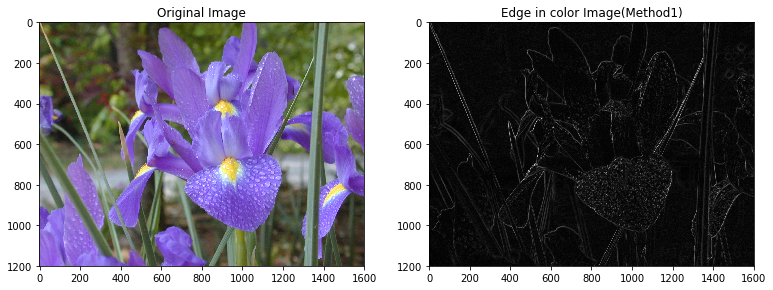

In [43]:
grad = np.sqrt(np.square(Rx) + np.square(Ry)) +\
        np.sqrt(np.square(Gx) + np.square(Gy)) + \
        np.sqrt(np.square(Bx) + np.square(By))
grad = ((grad - grad.min()) / (grad.max() - grad.min())) * 255 # rescale for full dynamic range for 8 bit image
grad = grad.astype(np.uint8)
plt.figure(figsize=(6.4*2, 4.8*2), constrained_layout=False)

plt.subplot(121), plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)), plt.title("Original Image")
plt.subplot(122), plt.imshow(grad,'gray'), plt.title("Edge in color Image(Method1)")

#cv2.imwrite('images/flower_gradient_direct_python.png',grad)

**方式二**

In [44]:
# 不要用np.power,比a**2,a*a慢很多
gxx = Rx**2 + Gx**2 + Bx**2
gyy = Ry**2 + Gy**2 + By**2
# np.multiply and the multiplication operator * work consistently for ndarray objects.
# 对于matrix对象才会有区别
gxy = Rx*Ry + Gx*Gy + Bx*By

In [45]:
eps = np.finfo(float).eps # 等于matlab中的eps
A = 0.5*(np.arctan(2*gxy/(gxx - gyy + eps)))
G1 = 0.5*((gxx + gyy) + (gxx - gyy)*np.cos(2*A) + 2*gxy*np.sin(2*A));
G1[G1<0]=0

# Now repeat for angle + pi/2. Then select the maximum at each point.
A = A + pi/2
G2 = 0.5*((gxx + gyy) + (gxx - gyy)*np.cos(2*A) + 2*gxy*np.sin(2*A));
G2[G2<0]=0

In [46]:
G1 = G1**0.5
G2 = G2**0.5
# Form VG by picking the maximum at each (x,y) and then scale
# to the range [0, 1].
VG = np.maximum(G1, G2)
# 将范围缩放至[0-1]
VG = (VG -np.min(VG))/(np.max(VG)-np.min(VG))

True

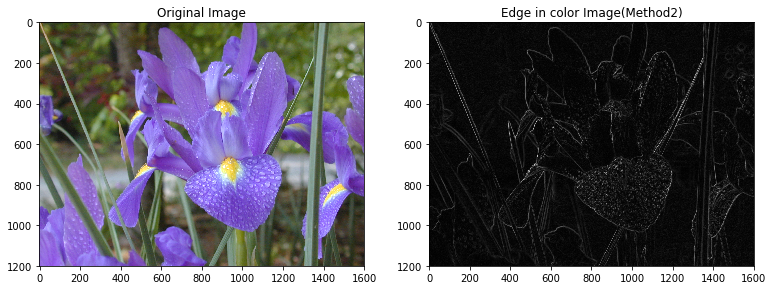

In [47]:
plt.figure(figsize=(6.4*2, 4.8*2), constrained_layout=False)

plt.subplot(121), plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)), plt.title("Original Image")
plt.subplot(122), plt.imshow(VG,'gray'), plt.title("Edge in color Image(Method2)")
cv2.imwrite('images/flower_gradient.png',(VG*255).astype('uint8'))